In [3]:
import pickle
import gensim
import pyLDAvis
import pyLDAvis.gensim
import spacy
import pandas as pd
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re
import warnings
from pprint import pprint
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iftek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
data_path = 'D:\\git_repos\\depression_suicide_project\\Pretrained_embedding_models\\dataset\\suicide\\CSSRS'

In [8]:
import os

In [25]:
df = pd.read_csv(os.path.join(data_path,'combined_CSSR_twitter_dataset.csv'))

In [44]:
df

,Unnamed: 0,Label,Post,text
0,2164,3,mechanical complication central nervous system...,mechanical complication central nervous system...
1,2809,4,try seek therapist help,try seek therapist help
2,125,2,family history senile dementia helpless psycho...,family history senile dementia helpless psycho...
3,1884,0,suicide self injury jump height assist suicide...,suicide self injury jump height assist suicide...
4,2730,1,intentional self harm shotgun intentional self...,intentional self harm shotgun intentional self...
...,...,...,...,...
3281,2864,3,think limited live country city tire large dat...,think limited live country city tire large dat...
3282,2975,3,idk talk want ready pretty confusing definitel...,idk talk want ready pretty confusing definitel...
3283,1799,0,suicide self inflict injury hang suicide self ...,suicide self inflict injury hang suicide self ...
3284,2611,0,die hospital suicide self inflict poison gas d...,die hospital suicide self inflict poison gas d...


In [56]:
df[df['Label'] == 0].shape[0]

717

In [27]:
df['text'] = df['Post']

In [28]:
# This part is need for the Label encoding
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df['Label'] = LE.fit_transform(df['Label'])
df = df.sample(frac=1).reset_index(drop=True)



In [23]:
LE.classes_

array(['Attempt', 'Behavior', 'Ideation', 'Indicator', 'Supportive'],
      dtype=object)

In [17]:
rev_train = df

In [29]:
rev_train['text_len'] = rev_train['text'].apply(lambda x: len(x.split()))

In [45]:
rev_train

,Unnamed: 0,Label,Post,text,text_len
0,0,2,epileptic dementia behavioral disturbance comm...,epileptic dementia behavioral disturbance comm...,57
1,1,3,fibrous tissue neoplasm skin haemophilus infec...,fibrous tissue neoplasm skin haemophilus infec...,74
2,2,3,mechanical complication skin graft failure rej...,mechanical complication skin graft failure rej...,65
3,3,2,hysterical blindness right temporal atrophy va...,hysterical blindness right temporal atrophy va...,63
4,4,2,think take overdose specific plan intend carry...,think take overdose specific plan intend carry...,62
...,...,...,...,...,...
3281,3281,4,end feel way entire lifetime fix thing persona...,end feel way entire lifetime fix thing persona...,406
3282,3282,3,skype end ventricular dysfunction leave good n...,skype end ventricular dysfunction leave good n...,149
3283,3283,4,sound weird maybe distractibility sound hypera...,sound weird maybe distractibility sound hypera...,2033
3284,3284,0,know dumb sound feel hyperactive behavior dese...,know dumb sound feel hyperactive behavior dese...,146


In [33]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['come','order','try','go','get','make','drink','plate','dish','restaurant','place',
#                   'would','really','like','great','service','came','got'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod
    
def get_corpus(df):
    df['text'] = strip_newline(df.text)
    words = list(sent_to_words(df.text))
    words = remove_stopwords(words)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [34]:
train_corpus, train_id2word, bigram_train = get_corpus(rev_train)

In [35]:
with open('train_corpus4.pkl', 'rb') as f:
    train_corpus4 = pickle.load(f)
with open('train_id2word4.pkl', 'rb') as f:
    train_id2word4 = pickle.load(f)
with open('bigram_train4.pkl', 'rb') as f:
    bigram_train4 = pickle.load(f)
# with open('lemma_train.pkl', 'rb') as f:
#     lemma_train = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'train_corpus4.pkl'

In [37]:
import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train4 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=5,
                           id2word=train_id2word,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
    lda_train4.save('lda_train.model')

In [38]:
lda_train4.print_topics(5,num_words=15)[:10]

[(0,
  '0.037*"know" + 0.028*"friend" + 0.021*"help" + 0.021*"need" + 0.020*"hospital" + 0.018*"tell" + 0.018*"talk" + 0.017*"cut" + 0.014*"feel" + 0.014*"therapist" + 0.013*"late" + 0.012*"school" + 0.011*"response" + 0.011*"bad" + 0.011*"cope"'),
 (1,
  '0.018*"feel" + 0.016*"think" + 0.016*"know" + 0.015*"people" + 0.015*"thing" + 0.015*"life" + 0.014*"want" + 0.011*"help" + 0.010*"time" + 0.010*"try" + 0.010*"good" + 0.009*"talk" + 0.009*"way" + 0.009*"well" + 0.008*"find"'),
 (2,
  '0.072*"intentional_self" + 0.030*"self_harm" + 0.025*"harm" + 0.014*"away" + 0.013*"stop" + 0.009*"give_thing" + 0.009*"write_note" + 0.009*"buy_gun" + 0.009*"say_goodbye" + 0.009*"buy_pill" + 0.009*"act" + 0.009*"purchase_gun" + 0.009*"substance" + 0.009*"get_gun" + 0.009*"self_destructive"'),
 (3,
  '0.077*"skin" + 0.014*"dementia" + 0.013*"nervous_system" + 0.012*"central_nervous" + 0.010*"system" + 0.008*"mood" + 0.007*"infection" + 0.007*"disease" + 0.006*"dementia_alzheimer" + 0.006*"bipolar_affe

In [40]:
lda_train4.get_document_topics(train_corpus[0], minimum_probability=0.0)

[(0, 0.0060896045),
 (1, 0.0060746367),
 (2, 0.006067119),
 (3, 0.975707),
 (4, 0.006061621)]

In [52]:
pd.Series(rev_train.iloc[0]['Label']).value_counts()


2    1
Name: count, dtype: int64

In [57]:
train_vecs = []
for i in range(len(rev_train)):
    top_topics = lda_train4.get_document_topics(train_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(5)]
#     topic_vec.extend(df[df['Label'] == i].shape[0]) # counts of reviews for restaurant
    topic_vec.extend([len(rev_train.iloc[i].text)]) # length review
    train_vecs.append(topic_vec)

In [66]:
train_vecs

[[0.006089589, 0.0060746353, 0.006067119, 0.975707, 0.006061621, 524],
 [0.004039943, 0.0040187393, 0.0040307874, 0.9839033, 0.004007246, 578],
 [0.004266182, 0.004272166, 0.00434634, 0.9828588, 0.00425654, 497],
 [0.006076765, 0.006100534, 0.006077236, 0.9756693, 0.006076111, 565],
 [0.005412598, 0.0054265796, 0.0054163225, 0.97833824, 0.005406196, 518],
 [0.0039105136, 0.0037980627, 0.0037788893, 0.98468083, 0.0038317407, 621],
 [0.0064550457, 0.006458856, 0.9741599, 0.0064532636, 0.0064729676, 372],
 [0.0064620716, 0.0064751497, 0.974139, 0.006455752, 0.0064680474, 407],
 [0.004597487, 0.1287238, 0.0045851655, 0.8575336, 0.004559993, 516],
 [0.006255208, 0.006288128, 0.006250968, 0.9749548, 0.006250958, 450],
 [0.006264099, 0.0062577217, 0.0062509137, 0.97497636, 0.006250904, 473],
 [0.006671222, 0.006669574, 0.9733176, 0.0066688247, 0.0066727344, 365],
 [0.020013183, 0.020000897, 0.9199734, 0.02001207, 0.020000473, 117],
 [0.0052775904, 0.005295627, 0.97888213, 0.0052693933, 0.0052

In [60]:
X = np.array(train_vecs)

In [61]:
y = np.array(rev_train.Label)

In [85]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# Assuming X and y are your features and labels

kf = KFold(5, shuffle=True, random_state=42)
cv_lr_f1, cv_lrsgd_f1, cv_svcsgd_f1, cv_nb_f1, cv_rf_f1, cv_mlp_f1, cv_svc_f1 = [], [], [], [], [], [], []

for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)

    # Logistic Regression
    lr = LogisticRegression(
        class_weight='balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)

    y_pred = lr.predict(X_val_scale)
    cv_lr_f1.append(f1_score(y_val, y_pred, average='weighted'))
    
    # Logistic Regression Mini-Batch SGD
    sgd = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        loss='log',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd.predict(X_val_scale)
    cv_lrsgd_f1.append(f1_score(y_val, y_pred, average='weighted'))
    
    # SGD Modified Huber
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd_huber.predict(X_val_scale)
    cv_svcsgd_f1.append(f1_score(y_val, y_pred, average='weighted'))
    
    # Multinomial Naive Bayes
    nb = MultinomialNB().fit(X_train, y_train)
    
    y_pred = nb.predict(X_val)
    cv_nb_f1.append(f1_score(y_val, y_pred, average='weighted'))
    
    # Random Forest
    rf = RandomForestClassifier(
        class_weight='balanced',
        n_estimators=100,
        random_state=42
    ).fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    cv_rf_f1.append(f1_score(y_val, y_pred, average='weighted'))
    
    # MLP Classifier
    mlp = MLPClassifier(
        hidden_layer_sizes=(100,),
        max_iter=300,
        random_state=42
    ).fit(X_train_scale, y_train)
    
    y_pred = mlp.predict(X_val_scale)
    cv_mlp_f1.append(f1_score(y_val, y_pred, average='weighted'))
    
    # Support Vector Classifier
    svc = SVC(
        class_weight='balanced',
        random_state=42
    ).fit(X_train_scale, y_train)
    
    y_pred = svc.predict(X_val_scale)
    cv_svc_f1.append(f1_score(y_val, y_pred, average='weighted'))

print(f'Logistic Regression Val f1: {np.mean(cv_lr_f1):.3f} +- {np.std(cv_lr_f1):.3f}')
print(f'Logistic Regression SGD Val f1: {np.mean(cv_lrsgd_f1):.3f} +- {np.std(cv_lrsgd_f1):.3f}')
print(f'SVM Huber Val f1: {np.mean(cv_svcsgd_f1):.3f} +- {np.std(cv_svcsgd_f1):.3f}')
print(f'MultinomialNB Val f1: {np.mean(cv_nb_f1):.3f} +- {np.std(cv_nb_f1):.3f}')
print(f'Random Forest Val f1: {np.mean(cv_rf_f1):.3f} +- {np.std(cv_rf_f1):.3f}')
print(f'MLP Classifier Val f1: {np.mean(cv_mlp_f1):.3f} +- {np.std(cv_mlp_f1):.3f}')
print(f'SVC Val f1: {np.mean(cv_svc_f1):.3f} +- {np.std(cv_svc_f1):.3f}')


C:\Users\iftek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\iftek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\iftek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\iftek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) 

Logistic Regression Val f1: 0.628 +- 0.016
Logistic Regression SGD Val f1: 0.655 +- 0.035
SVM Huber Val f1: 0.489 +- 0.203
MultinomialNB Val f1: 0.660 +- 0.020
Random Forest Val f1: 0.889 +- 0.007
MLP Classifier Val f1: 0.825 +- 0.025
SVC Val f1: 0.664 +- 0.016


C:\Users\iftek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


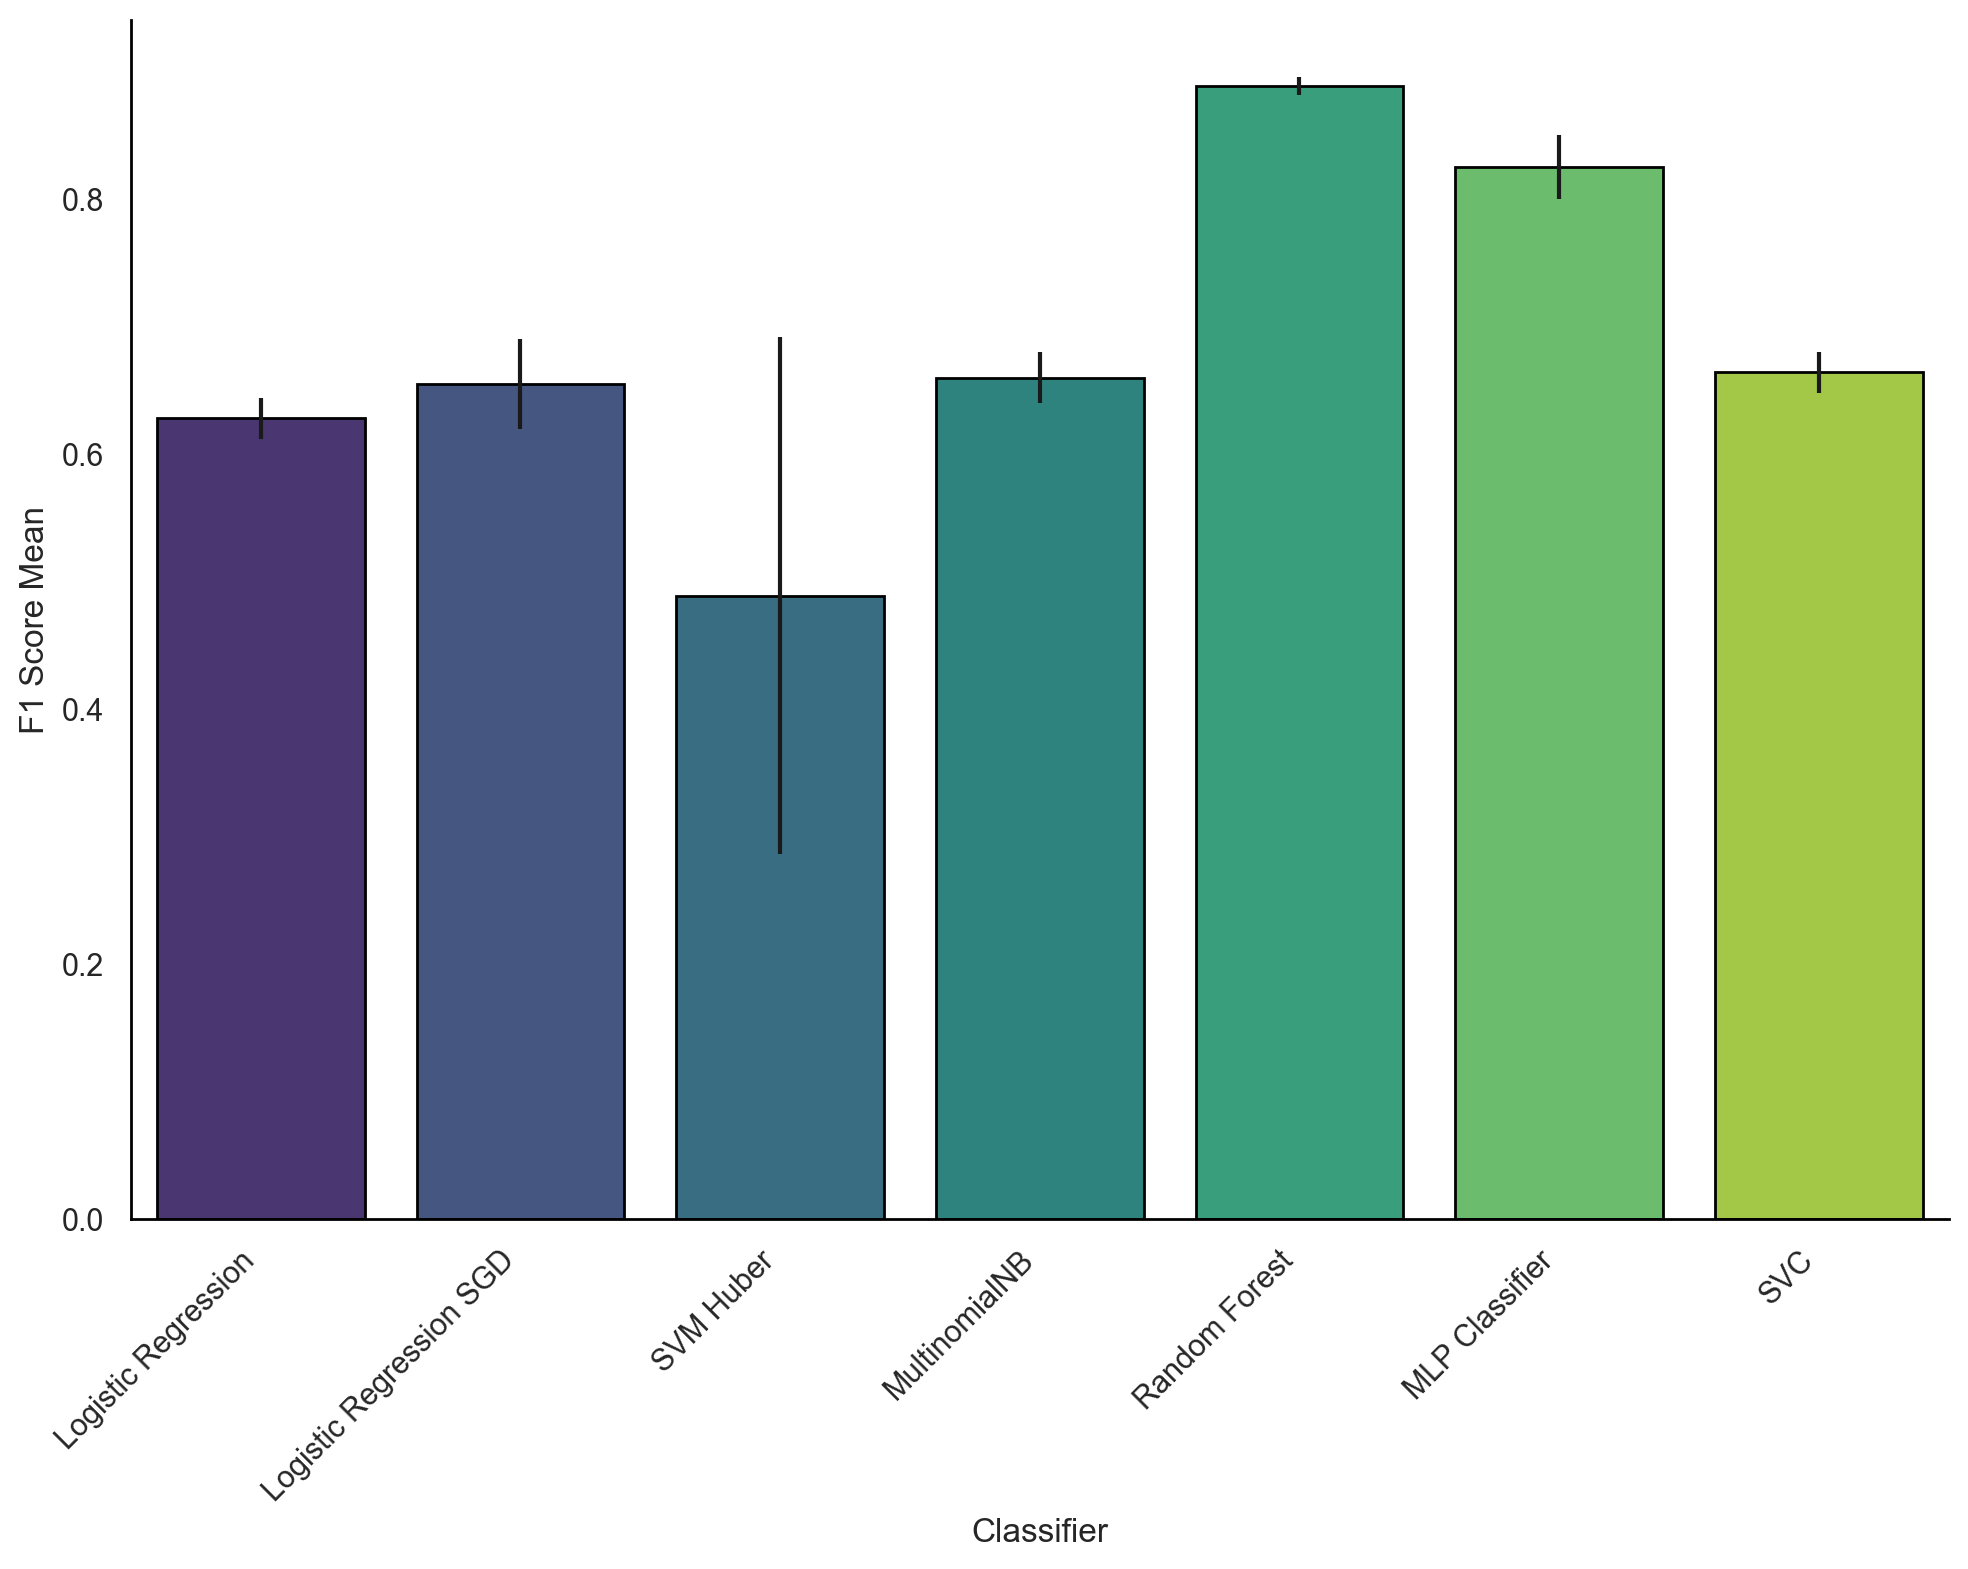

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data
data = {
    'Classifier': [
        'Logistic Regression', 
        'Logistic Regression SGD', 
        'SVM Huber', 
        'MultinomialNB', 
        'Random Forest', 
        'MLP Classifier', 
        'SVC'
    ],
    'F1 Score Mean': [0.628, 0.655, 0.489, 0.660, 0.889, 0.825, 0.664],
    'F1 Score Std': [0.016, 0.035, 0.203, 0.020, 0.007, 0.025, 0.016]
}

df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 8))  # Adjust the figure size as per your preference
bar_plot = sns.barplot(
    x='Classifier', 
    y='F1 Score Mean', 
    data=df, 
    palette='viridis',
    yerr=df['F1 Score Std'],  # Specify error bars for y-axis (optional)
    orient='v'  # Specify 'v' for vertical orientation
)

# Adding the border to the bars
for bar in bar_plot.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

# Adding Titles and Labels
# plt.title('Classifier F1 Scores with Standard Deviation', fontsize=14)
plt.xlabel('Classifier', fontsize=12)
plt.ylabel('F1 Score Mean', fontsize=12)

# Removing the grid
sns.despine()

# Adding border to x-axis and y-axis
plt.gca().spines['left'].set_color('black')
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['bottom'].set_linewidth(1)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
# Display the plot
plt.tight_layout()
plt.show()
